## Image Analysis

The aim of this section is the extraction of information from images.  We are going to focus on two cases:

* Image structure
* Object recognition

### Image Structure

The goal is the representation of the contents of an image using simple structures.  We focus on one case alone: *Image segmentation*.

#### Segmentation

This is a method to represent an image by partition into multiple  objects (segments), each of them sharing some common property.

In the case of binary images we may accomplish this by labeling, as we have shown in a previous section.  Let us revisit that technique with an artificial image composed by 30 random disks placed on a 64-by-64 canvas.


In [4]:
import numpy as np, matplotlib.pyplot as plt

%matplotlib inline

from skimage.draw import circle

image = np.zeros((64, 64)).astype('bool')

for k in range(30):
    x0, y0 = np.random.randint(64, size=(2))
    image[circle(x0, y0, 3)] = True

from scipy.ndimage import label

labels, num_features = label(image)

The object `labels` can be regarded as another image, where each of the different objects found in the original `image` has been given a different number.  The background of the image is also considered one more object, and received the number `0` as label.  Its visual representation (on the right in the following figure) presents all the objects from `image`, each of them with a different color.

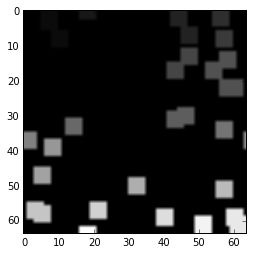

In [6]:
plt.imshow(labels)
plt.gray()

For gray-scale or color images, the process of segmentation is more complex.  We can often reduce such an image to a binary representation of the relevant areas (by some kind of thresholding operation after treatment with morphology), and then apply a labeling process.  But this is not always possible.  Take for example the image `skimage.data.coins`.  In this image, the background shares the same range of intensity as many of the coins in the background.  A thresholding operation will result in failure to segment effectively.

We have more advanced options. 

* Clustering methods, using as distance between pixels the difference between their intensities/colors.  
* Compression-based methods. 
* Histogram-based methods, where we use the peaks and valleys in the histogram on an image to break it into segments.
* Region-growing methods.
* Methods based on Partial Differential Equations.
* Variational methods.
* Graph-partitioning methods.
* Watershed methods. 

From the standpoint of the `scipy` stack, we have mainly two options: a combination of tools from `scipy.ndimage`, a few segmentation routines in the module `skimage.segmentation`

> There is also a very robust set of implementations via bindings to the powerful library `ITK` (*Insight Segmentation and Registration Toolkit*). For general information on the library `ITK`, the best resource is its official site at http://www.itk.org.

> We use a simplified wrapper build on top of it: the `python` distribution of `SimpleITK`. This package brings most of the functionality of `ITK` through bindings to `python` functions.   For documentation, downloads and installation, go to http://www.simpleitk.org   

> Unfortunately, at the time this book is being written, the installation is very tricky.  Successful installations depend heavily of your `python` installation, computer system, libraries installed, etc.

Let us show by example the usage of some of these techniques on the particularly tricky image `skimage.data.coins`.  For instance, to perform a simple histogram-based segmentation, we could proceed in these lines:

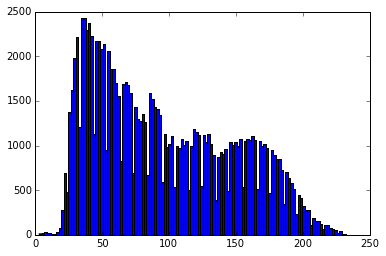

In [7]:
from skimage.data import coins
from scipy.ndimage import gaussian_filter

image = gaussian_filter(coins(), sigma=0.5)

plt.hist(image.flatten(), bins=128)
plt.show() 

> Note how we performed first a smoothing of the original image by convolution with a spherical Gaussian filter.  This is standard procedure to cancel possible unwanted signal and obtain cleaner results.

There seems to be a clear valley around the intensity 80, in between peaks at intensities 35 and 85.  There is another valley around the intensity 112, followed by a peak at intensity 123.  There is one more valley around intensity 137, followed by a last peak at intensity 160.  We use this information to create four segments:

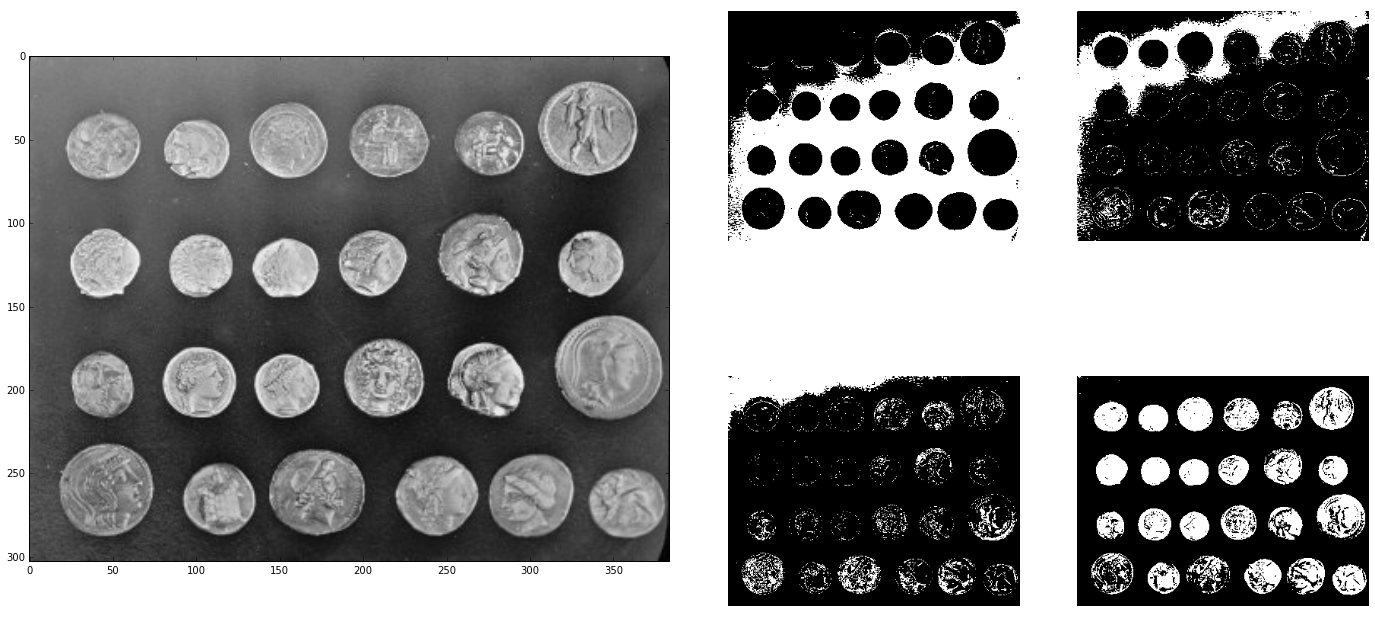

In [8]:
level_1 = coins()<=80
level_2 = (coins()>80) * (coins()<=112)
level_3 = (coins()>112) * (coins()<=137)
level_4 = coins()>137

plt.figure(figsize=(24,12))
plt.subplot2grid((2,4), (0,0), colspan=2, rowspan=2)
plt.imshow(coins())
plt.gray()
plt.subplot2grid((2,4),(0,2))
plt.imshow(level_1)
plt.axis('off')
plt.subplot2grid((2,4),(0,3))
plt.imshow(level_2)
plt.axis('off')
plt.subplot2grid((2,4), (1,2))
plt.imshow(level_3)
plt.axis('off')
plt.subplot2grid((2,4), (1,3))
plt.imshow(level_4)
plt.axis('off')
plt.show()

With a slight modification of the fourth level, we shall obtain a decent segmentation.

In [10]:
from scipy.ndimage.morphology import binary_fill_holes

level_4 = binary_fill_holes(level_4)

labels, num_features = label(level_4)

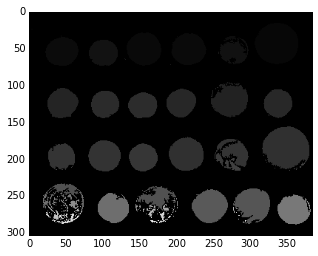

In [11]:
plt.imshow(labels)

The result is not optimal.  The process has missed a good segmentation of some coins in the fifth column, but mainly in the lowest row.

Improvements can be made if we provide a marker for each of the segments we are interested in obtaining.  For instance, we may assume known at least one point inside of the locations of those 24 coins.  We could use then a watershed transform for that purpose.  In the module `scipy.ndimage` we have an implementation of this process based on the iterative forest transform.

In [12]:
from scipy.ndimage import watershed_ift

markers_x = [50, 125, 200, 255]
markers_y = [50, 100, 150, 225, 285, 350]

markers = np.zeros_like(image).astype('int16')
markers_index = [[x,y] for x in markers_x for y in markers_y]

for index, location in enumerate(markers_index):
    markers[location[0], location[1]] = index+5

segments = watershed_ift(image, markers)

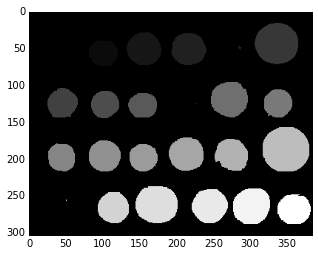

In [13]:
plt.imshow(segments)

We can further improve the segmentation by employing, for instance, a graph-partitioning method, like a *random walker*.

In [14]:
from skimage.segmentation import random_walker

segments = random_walker(image, markers)

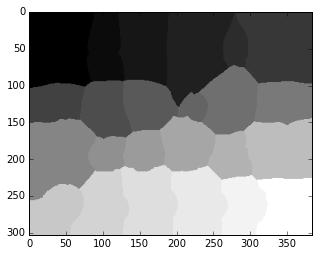

In [15]:
plt.imshow(segments)

This process correctly breaks the image in 24 well-differentiated regions, but does not resolve well the background.  To take care of this situation, we manually mark with a `-1` regions we believe are background.  We may use the previously calculated masks `level_1` and `level_2` ---they clearly represent image background--- for these purposes.

In [18]:
markers[level_1] = markers[level_2] = -1

segments = random_walker(image, markers)

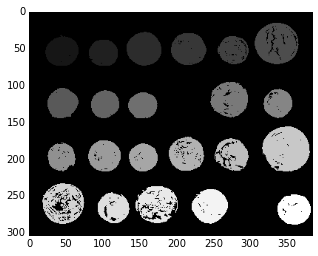

In [19]:
plt.imshow(segments)

For other segmentation techniques, browse the different routines in the module `skimage.segmentation`.

### Object recognition

Many possibilities arise.  Given an image, we may need to collect the location of simple geometric features like edges, corners, linear, circular or elliptical shapes, polygonal shapes, blobs, etc.  We may also need to find more complex objects like faces, numbers, letters, planes, tanks, etc.  Let us examine some examples that we can easily code from within the `scipy` stack.

#### Edge detection

An implementation of Canny's edge detector can be found in the module `skimage.feature`.  This implementation performs a smoothing of the input image, followed of vertical and horizontal Sobel operators, as aid for the extraction of edges.

In [20]:
from skimage.feature import canny

edges = canny(coins(), sigma=3.5)

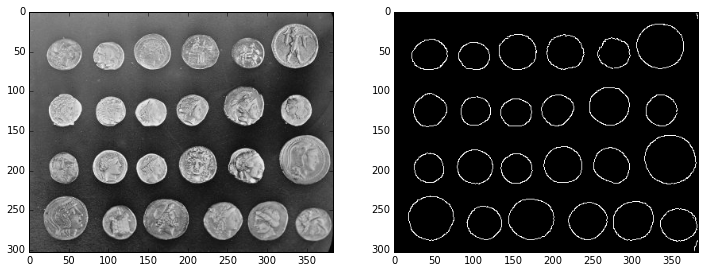

In [25]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(coins())
plt.subplot(122)
plt.imshow(edges)
plt.show()

#### Line, circle, ellipse detection

For detection of these basic geometric shapes, we have the aid of the *Hough transform*.  A very robust implementation can be found in the module `skimage.transform`.  Let us examine its usage in tracking these objects for an artificial binary image.  Let us place an ellipse with center `(10, 10)` and radii 9 and 5 (parallel to the coordinate axes), a circle with center `(30, 35)` and radius 8, and a line between the points `(0, 3)` and `(64, 40)`.

In [26]:
from skimage.draw import line, ellipse_perimeter, circle_perimeter

image = np.zeros((64, 64)).astype('bool')
image[ellipse_perimeter(10, 10, 9, 5)] = True
image[circle_perimeter(30, 35, 15)] = True
image[line(0, 3, 63, 40)] = True

To use the Hough transform for line, we compute the corresponding H space (the accumulator), and extract the location of its peaks.  In the case of the line version of the Hough transform, the axes of the accumulator represent the angle $\theta$ and distance from the origin $r$ in the Hesse normal form of a line ($r = x \cos(\theta)+ y \sin(\theta)$).  The peaks in the accumulator then indicate the presence of the most relevant lines of the given image.

In [27]:
from skimage.transform import hough_line, hough_line_peaks

Hspace, thetas, distances = hough_line(image)
hough_line_peaks(Hspace, thetas, distances)

(array([52], dtype=uint64), array([-0.51774851]), array([ 3.51933702]))

This output means: there is only one significant peak in the H-space of the Hough transform of `image`.  This peaks corresponds to a line with Hesse angle `-0.51774851` radians, and `3.51933702` units from the origin: $3.51933702 = \cos(-0.51774851) x + \sin(-0.51774851) y$.

Let us see the original image together with the detected line.

In [28]:
def hesse_line(theta, distance, thickness):
    return lambda i, j: np.abs(distance - np.cos(theta)*j - np.sin(theta)*i) < thickness

peak, theta, r = hough_line_peaks(Hspace, thetas, distances)

detected_lines = np.fromfunction(hesse_line(theta, r, 1.), (64, 64))

> Note the inversion of the roles of the coordinates `i` and `j` in the definition of `hesse_line`.  Why did we have to perform this artificial change of coordinates?

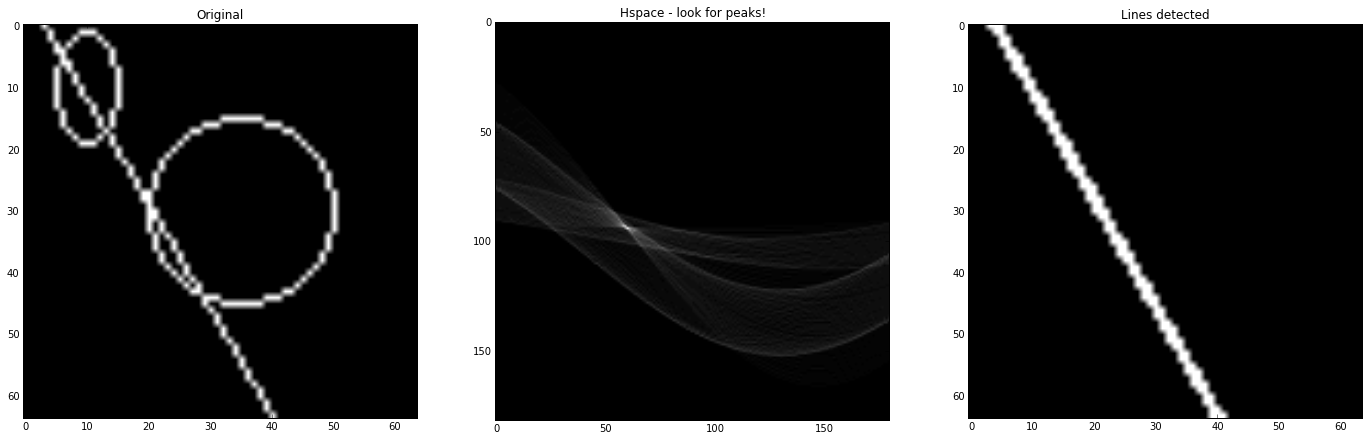

In [29]:
plt.figure(figsize=(24,12))
plt.subplot(131)
plt.imshow(image)
plt.title('Original')
plt.subplot(132)
plt.imshow(Hspace)
plt.title('Hspace - look for peaks!')
plt.subplot(133)
plt.imshow(detected_lines)
plt.title('Lines detected')
plt.show()


The detection of circles and ellipses obeys a similar philosophy of computing an accumulator in some H-space, and track its peaks.  For example, if we are seeking circles with radii equal to 15, and we wish to recover their centers, we could issue something in the following lines:

In [30]:
from skimage.transform import hough_circle

detected_circles = hough_circle(image, radius=np.array([15]))

np.where(detected_circles == detected_circles.max())

(array([0]), array([30]), array([35]))

The array `detected_circles` has shape `(1, 64, 64)`.  The first index of the last output is thus irrelevant.  The other two reported indices indicate that the center of the detected circle is precisely `(30, 35)`.

#### Blob detection

We may regard a *blob* as a region of an image where all its pixels share a common property.  For instance, after segmentation, each of the segments are blobs.  

There are some relevant routines in the module `skimage.feature` to this effect: `blob_doh` (a method based on determinants of Hessians), `blob_dog` (by differential of Gaussians), and `blob_log` (a method based on the Laplacian of Gaussians).  The first approach ensures the extraction of more samples, and if faster than the others.

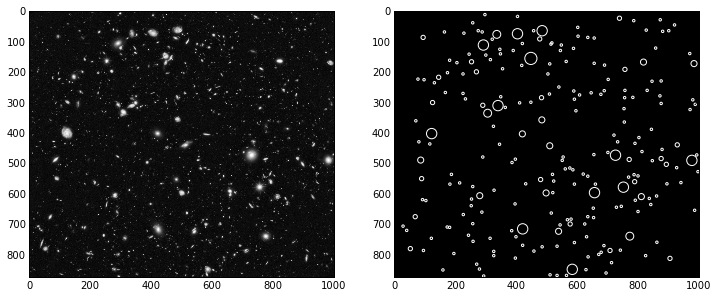

In [33]:
from skimage.data import hubble_deep_field
from skimage.feature import blob_doh
from skimage.color import rgb2gray

image = rgb2gray(hubble_deep_field())

blobs = blob_doh(image)

plt.figure(figsize=(12,6))
ax1 = plt.subplot(121)
ax1.imshow(image)
plt.gray()
ax2 = plt.subplot(122)
ax2.imshow(np.zeros_like(image))

for blob in blobs:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='white', lw=1, fill=False)
    ax2.add_patch(c)

plt.show()

#### Corner detection

A corner is that location where two non-aligned edges intersect.  This is one of the most useful operations in image analysis, since many complex structures require a careful location of these features.  The applications range from complex object or motion recognition, to video tracking, 3D modeling, or image registration.

In the module `skimage.feature` we have implementations of some of the best known algorithms to solve this problem:

* *FAST corner detection* (features from accelerated segment test): `corner_fast`.
* *Förstner corner detection* for subpixel accuracy: `corner_foerstner`. 
* *Harris corner measure response* (the basic method): `corner_harris`.
* *Kitchen and Rosenfeld corner measure response*: `corner_kitchen_rosenfeld`.
* *Moraved corner measure response*. Simple, fast, but not capable of detecting corners where the adjacent edges are not perfectly straight: `corner_moravec`.
* *Kanade-Tomasi corner measure response*: `corner_shi_tomasi`.

We also have some utilities to determine the orientation of the corners, or their subpixel position.

Let us explore the occurrence of corners in `skimage.data.text`.

In [36]:
from skimage.feature import corner_fast, corner_orientations, corner_peaks
from skimage.data import text

mask = np.ones((5,5))

corner_response = corner_fast(text(), threshold=0.2)
corner_pos = corner_peaks(corner_response)
corner_orientation = corner_orientations(text(), corner_pos, mask)

for k in range(5):
    y, x = corner_pos[k]
    angle = np.rad2deg(corner_orientation[k])
    print "Corner at ({}, {}) with orientation {}".format(x,y,angle)

Corner at (154, 11) with orientation 76.147664151
Corner at (257, 26) with orientation -139.929752986
Corner at (269, 30) with orientation 13.8150253413
Corner at (242, 32) with orientation -152.456558134
Corner at (10, 37) with orientation 31.4534521252


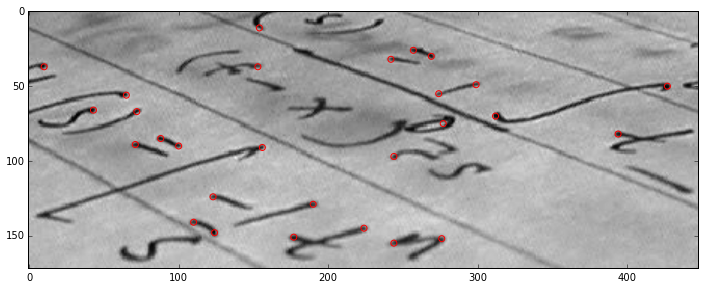

In [38]:
plt.figure(figsize=(12,6))
ax = plt.subplot(111)
ax.imshow(text())
plt.gray()

for corner in corner_pos:
    y, x = corner
    c = plt.Circle((x, y), 2, lw=1, fill=False, color='red')
    ax.add_patch(c)

plt.show()

#### Beyond geometric entities

Object detection is not limited to geometric entities.  In this subsection we explore some methods of tracking more complex objects.  

In the scope of binary images, a simple correlation is often enough to achieve a somewhat decent object recognition.  The following example tracks most of the letter e's on an image depicting the first paragraph of "Don Quixote" by Miguel de Cervantes.  

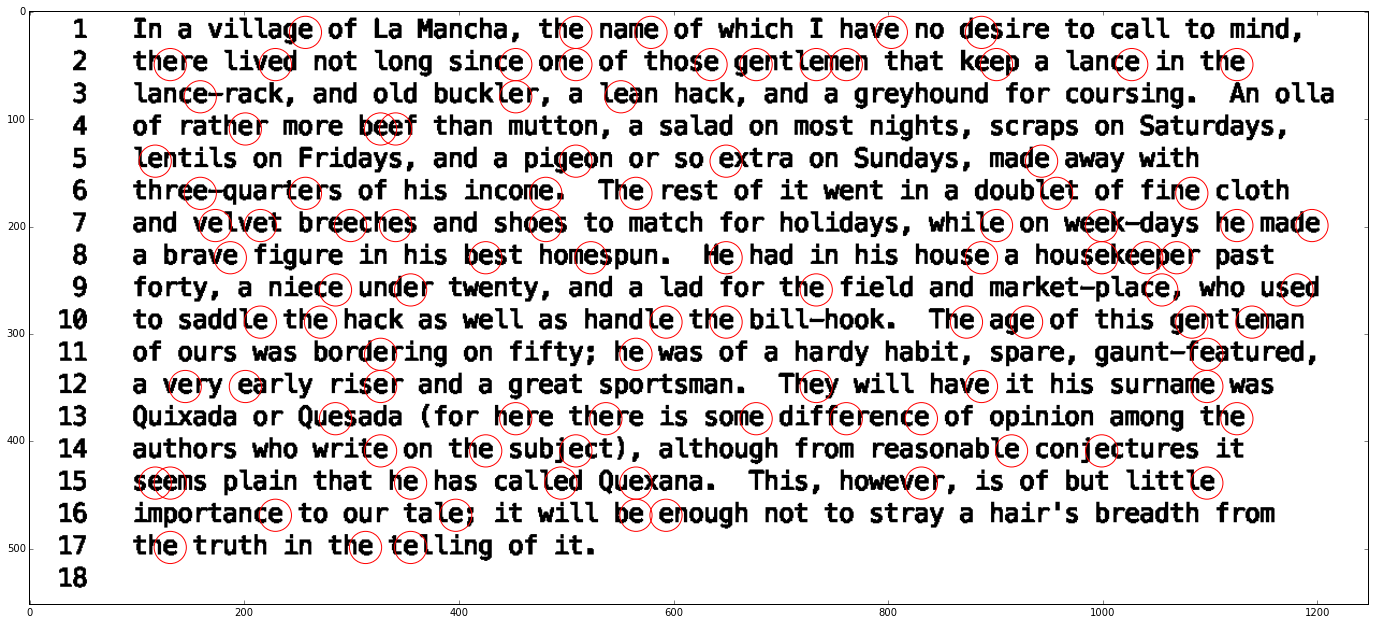

In [40]:
from scipy.misc import imread

quixote = imread('quixote.tiff')
bin_quixote = (quixote[:,:,0]<50)
letter_e = quixote[10:29, 250:265]
bin_e = bin_quixote[10:29, 250:265]

from scipy.ndimage.morphology import binary_hit_or_miss

x, y = np.where(binary_hit_or_miss(bin_quixote, bin_e))

plt.figure(figsize=(24,12))
ax = plt.subplot(111)
ax.imshow(bin_quixote)

for loc in zip(y, x):
    c = plt.Circle((loc[0], loc[1]), 15, color='red', fill=False)
    ax.add_patch(c)

plt.show()

Small imperfections or slight change of size in the rendering of the text makes correlation not a perfect detection mechanism.

An improvement, that can be applied to gray-scale or color images, is through the routine `matchTemplate` in the `imgproc` module of `OpenCV`:

In [41]:
from cv2 import matchTemplate, TM_SQDIFF

detection = matchTemplate(quixote, letter_e, TM_SQDIFF)
x, y = np.where(detection <= detection.mean()/8.)

plt.figure()
ax = plt.subplot(111)
ax.imshow(quixote)

for loc in zip(y, x):
    r = pltRectangle((loc[0], loc[1]), 15, 19, fill=False)
    ax.add_patch(r)

plt.show()

ImportError: No module named cv2

All the letter e's get correctly detected now. 	

Let us finish the chapter with a more complex case of object detection.  We are going to employ a *Haar feature-based cascade classifier*: this is an algorithm that applies a machine learning based approach to detect faces and eyes from some training data.   

First, locate in your `opencv` installation folder, the `haarcascades` subfolder.  In my `anaconda` installation, for instance this is at `/anaconda/pkgs/opencv-2.4.9-np19py27_0/share/OpenCV/haarcascades`.  From that folder we are going to need the databases for frontal faces (`haarcascade_frontalface_default.xml`), and eyes (`haarcascade_eye.xml`).


In [ ]:
from cv2 import CascadeClassifier
from skimage.data import lena

In [72]: face_cascade = CascadeClassifier('haarcascade_frontalface_default.xml'); \
   ....: eye_cascade = CascadeClassifier('haarcascade_eye.xml')

In [73]: faces = face_cascade.detectMultiScale(lena()); \
   ....: eyes = eye_cascade.detectMultiScale(lena())

In [74]: print faces
[[212 199 179 179]]

In [75]: print eyes